In [1]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import cv2,PIL,urllib,validators,os
import numpy as np
import seaborn as sns
sns.set()
emotions={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
class FaceExpressionRecognition():
    """
    Detect faces and facial expressions.
    """
    def __init__(self,scale=1.1,neighbor=5,target_res=(48,48)):
        
        """
        scale: Parameter for detecting faces.
        neighbor :Parameter for detecting faces.
        If model cant find all faces try to reduce scale and neighbor.
        """
        
        #loading model
        self.model=load_model('saved_models/best_model.h5')
        #params for detecting face
        self.scale=scale
        self.neighbor=neighbor
        #resolution that cnn model needed
        self.target=target_res
        
    
    def detect_faces(self,img):
        """
        Detect faces from given image with opencv cascade classifier and return list of faces.
        img: np.array.
        return: np.array.
        """
 
        cropped=[]
        face_cascade=cv2.CascadeClassifier('face detect/haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(img,scaleFactor=self.scale,minNeighbors=self.neighbor)
        if len(faces)==0:
                return [img]
        for x,y,w,h in faces:
            cropped.append(img[y:y+w,x:x+h])
        return cropped
    
    
    def predict(self,path,detect_faces=True):
        """
        Takes local path or url of image and returns img with cnn model predictions.
        path: file path or url
        detect_faces: if False model predict directly at given img
                      if True model try to find faces in img and predict each of them. 
                      When image contains multiple faces or face in the image is far, 
                      highly suggest to set True.
                      If model cant find all faces try to reduce scale and neighbor
                      while creating FaceExpressionRecognition object.
        """
        #checks path is url
        if validators.url(path):
                img=np.array(PIL.Image.open(urllib.request.urlopen(path)))
                img=cv2.cvtColor(img,cv2.COLOR_RGBA2GRAY)
        if not validators.url(path):
                img=cv2.imread(path,0)
        img_org=img
        if detect_faces:
                img=(self.detect_faces(img))
        else:
            img=[img]
        return self.exp_recog(img)
    
            
    def exp_recog(self,img):
        """Predict facial expressions."""
        
        preds=[]
        for i in img:
            i=cv2.resize(i,self.target)
            i=i.reshape(-1,self.target[0],self.target[1],1)/255
            pred=self.model.predict(i)
            pred=pred.reshape(7)
            preds.append(dict(zip(emotions.values(),pred*100)))
        return (img,preds)
            
    def plot_results(self,img,preds):
        """Plots the results."""
        
        fig,axes=plt.subplots(ncols=2,nrows=len(img),figsize=(12,len(img)*2.5))
        for i in range(len(img)):
            if len(img)==1:
                axes[i].imshow(img[i],cmap='gray')
                axes[i].axis('off')
                sns.barplot(y=list(preds[i].values()),x=list(preds[i].keys()),ax=axes[1])
            else:
                axes[i][0].imshow(img[i],cmap='gray')
                axes[i][0].axis('off')
                sns.barplot(y=list(preds[i].values()),x=list(preds[i].keys()),ax=axes[i][1])
        plt.subplots_adjust(wspace=-0.11)
        plt.tight_layout()
        plt.show()

In [48]:
FER=FaceExpressionRecognition(scale=1.25,neighbor=5)

In [61]:
img,preds=(FER.predict('http://c.files.bbci.co.uk/90C1/production/_111775073_gettyimages-517323960.jpg',detect_faces=True))

{'Angry': 19.787678,
 'Disgust': 0.30649757,
 'Fear': 11.07729,
 'Happy': 0.8529271,
 'Sad': 28.14129,
 'Surprise': 0.4459403,
 'Neutral': 39.38838}

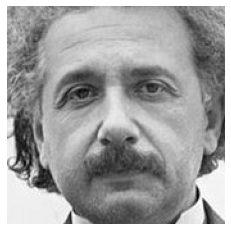

In [62]:
plt.imshow(img[0],cmap='gray');
plt.axis('off')
preds[0]

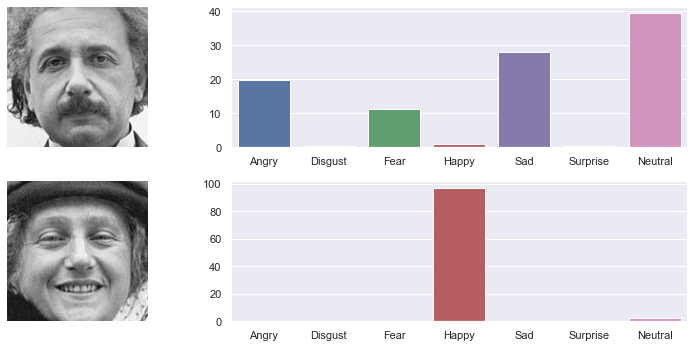

In [63]:
FER.plot_results(img,preds)